## ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ «МОСКОВСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ ИМЕНИ Н.Э. БАУМАНА

### Центр дополнительного образования МГТУ им. Н.Э. Баумана


### Отчет о выполнении итогового задания


## Выполнил: Куликов Алексей Сергеевич

___

### Задача: 
необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.
Группы могут быть следующими:
1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.
По ОКПД-2 контракты в общем случае должны разделяться так:
Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
Проектно-изыскательские работы (ПИР) - 41.1, 71.1
Подключение коммуникаций - 43.22
Строительный надзор – четкой группы нет.
### Проблема: 
Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.
Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.
Иногда контракт может одновременно относиться к нескольким группам.


___

<H3>На данном шаге мы изучим файл, очистим его от столбцов, которые не помогут в дальнейшей работе
    
В результате получим файл для анализа и работы</H3>

In [1]:
# Библиотеки
import os

import pandas as pd
from tqdm import tqdm

In [2]:
# Отключаем предупреждения. Мы знаем, что делаем
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Названия столбцов из презентации
COLUMNS = ["x1", "Реестровый номер контракта", "x2", "x3", "x4", "x5", 
           "x6", "x7", "x8", "x9", "x10", "x11", "x12", 
           "date1", "date2", "date3", "date4", "date5", "date6", "x13", "x14", 
           "x15", "x16", "x17", "x18", "y_description", "y"]

# Количество строк для считывания
ROWS = 10 ** 6

In [4]:
# Чтение как из презентации
df = pd.read_csv('datasets/fz.csv', nrows=ROWS,
                 on_bad_lines="skip", names=COLUMNS,
                 encoding="utf-8", low_memory=False)

# Изучение файла

Рассмотрим, что из себя представляет файл, чтобы выделить необходимые столбцы

## Базовая информация

In [5]:
# Пример данных
# Берем первую строку по индексу, транспонируем для красивого вывода
df.iloc[0].T

x1                                                                            1
Реестровый номер контракта                                  1010101008321000006
x2                                         211010101008301010100100100246820244
x3                                                                   7707049388
x4                                      КРАСНОДАРСКИЙ ФИЛИАЛ ПАО \РОСТЕЛЕКОМ\""
x5                                                              <НЕ ОПРЕДЕЛЕНО>
x6                                                                   0101010083
x7                                              МО МВД РОССИИ \КОШЕХАБЛЬСКИЙ\""
x8                                                   Республика Адыгея (Адыгея)
x9                                                         18803020840390049244
x10                                                           Контракт исполнен
x11                                                             <НЕ ОПРЕДЕЛЕНО>
x12                                     

Предположим, что символ каретки '\N' означает пропуск в данных, учтем это

In [6]:
# Выводим незаполненные значения и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 27 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   x1                          1000000 non-null  int64 
 1   Реестровый номер контракта  1000000 non-null  int64 
 2   x2                          1000000 non-null  object
 3   x3                          1000000 non-null  int64 
 4   x4                          1000000 non-null  object
 5   x5                          1000000 non-null  object
 6   x6                          1000000 non-null  object
 7   x7                          1000000 non-null  object
 8   x8                          1000000 non-null  object
 9   x9                          1000000 non-null  object
 10  x10                         1000000 non-null  object
 11  x11                         1000000 non-null  object
 12  x12                         1000000 non-null  object
 13  date1        

In [7]:
# Замена символов, которые указывают на незаполненные значения
# Были представлены выше
df.replace(dict.fromkeys(['\\N', '<НЕ ОПРЕДЕЛЕНО>'], None), inplace=True)

In [8]:
# Смотрим пустые значения с заменой
df.isna().sum()

x1                                 0
Реестровый номер контракта         0
x2                            360741
x3                                 0
x4                                 0
x5                            295422
x6                                 5
x7                             50942
x8                                55
x9                            415178
x10                               24
x11                            95395
x12                           336447
date1                              0
date2                             16
date3                             55
date4                            453
date5                         291643
date6                         829888
x13                           828730
x14                            95483
x15                              816
x16                           755534
x17                           867941
x18                           993399
y_description                   1337
y                               1973
d

Также внимательно изучим сам файл. Ниже представлен пример дат из файла

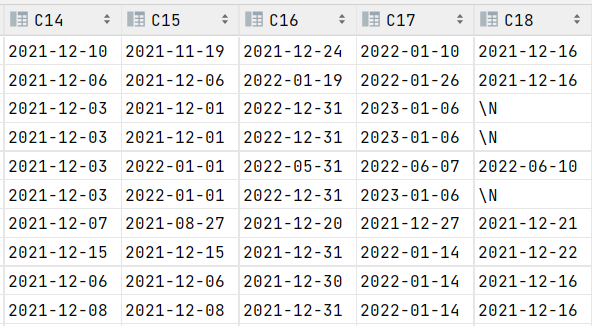

Исходим из той логики, что столбец C15 ведет отсчет раньше, а столбец C17 позже остальных. 

Возьмем за рассчет эти две даты при получении выборки для работы

**Вывод**:

Большая часть столбцов не несет смысловой нагрузки, и не понадобится в дальнейшей работе

## Отдельные столбцы

Сначала удалим столбцы с большим количеством пропусков

In [9]:
# Результирующие столбцы
COLS = ['Реестровый номер контракта', 'x4', 'x7', 'x8', 'x11', 'x12', 'x15', 'date2', 'date4', 'y_description', 'y']

In [10]:
# Оставляем только выбранные столбцы
df = df[COLS]

In [11]:
# Выводим информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   Реестровый номер контракта  1000000 non-null  int64 
 1   x4                          1000000 non-null  object
 2   x7                          949058 non-null   object
 3   x8                          999945 non-null   object
 4   x11                         904605 non-null   object
 5   x12                         663553 non-null   object
 6   x15                         999184 non-null   object
 7   date2                       999984 non-null   object
 8   date4                       999547 non-null   object
 9   y_description               998663 non-null   object
 10  y                           998027 non-null   object
dtypes: int64(1), object(10)
memory usage: 83.9+ MB


In [12]:
# Выводим пример данных
df.iloc[1].T

Реестровый номер контракта                              1010101008321000006
x4                            ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО \РОСТЕЛЕКОМ\""
x7                                          МО МВД РОССИИ \КОШЕХАБЛЬСКИЙ\""
x8                                               Республика Адыгея (Адыгея)
x11                                                                    None
x12                                                      федеральный бюджет
x15                                                               173380.50
date2                                                            2021-01-01
date4                                                            2022-01-14
y_description                   Услуги по операциям с недвижимым имуществом
y                                                                      68.2
Name: 1, dtype: object

Как можно заметить, в данных присутствуют пропуски в столбце **x11** - описание контракта.

При полной обработке файла необходимо удалить данные с пустыми значениями

In [13]:
row = df.dropna().iloc[0].T
row

Реестровый номер контракта                                  1010501691421000144
x4                            ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ \КРУС...
x7                            ГУ-РО ФОНДА СОЦИАЛЬНОГО СТРАХОВАНИЯ РОССИЙСКОЙ...
x8                                                   Республика Адыгея (Адыгея)
x11                           На поставку специальных устройств для чтения «...
x12                           бюджет Фонда социального страхования Российско...
x15                                                                   281119.60
date2                                                                2021-12-01
date4                                                                2022-10-07
y_description                 Оборудование компьютерное, электронное и оптич...
y                                                                          26.4
Name: 3, dtype: object

In [14]:
# Выведем отдельно текстовые данные
row['x11'], row['x12'], row['y_description']

('На поставку специальных устройств для чтения «говорящих книг» - базовых тифлофлешплееров для обеспечения инвалидов в 2022 году',
 'бюджет Фонда социального страхования Российской Федерации',
 'Оборудование компьютерное, электронное и оптическое')

Строки представляют собой:

* Контракт
* Бюджет
* Описание категории

Данные описания пригодятся в дальнейшем

# Получение выборки для анализа

Полностью обработаем весь файл по "кусочкам", оставив только необходимые данные, очистив от строк с пустыми значениями

Учитывая размер выборки, потери не будут значимыми при обучении модели

In [15]:
def process_large_file(input_file, output_file, columns, chunk_size=10**5):
    """
    Обработка большого файла пакетами и сохранение выбранных колонок в новый файл.
    
    Parameters:
    - input_file: Путь к исходному CSV файлу.
    - output_file: Путь к выходному CSV файлу.
    - columns: Список колонок для сохранения.
    - chunk_size: Количество строк для чтения в каждом пакете.
    """
    # Флаг для определения, нужно ли добавлять заголовки в выходной файл (только для первого пакета)
    write_header = True

    # Удаляем файл перед записью
    os.remove(output_file)
    
    # Чтение файла пакетами с использованием контекстного менеджера
    with pd.read_csv(input_file, encoding='utf-8', names=COLUMNS,
                     chunksize=chunk_size, on_bad_lines="skip", low_memory=False) as reader:
        for chunk in tqdm(reader):
            # Оставляем только нужные колонки
            chunk_selected = chunk[columns]

            # Очищаем данные
            chunk_selected = chunk_selected.replace(dict.fromkeys(['\\N', '<НЕ ОПРЕДЕЛЕНО>'], None)).dropna()
            
            # Добавляем данные в выходной файл
            chunk_selected.to_csv(output_file, mode='a', header=write_header, index=False)
            
            # После записи первого пакета меняем флаг добавления заголовка
            write_header = False

In [16]:
# Входной и выходной файлы
input_filepath = "datasets/fz.csv"
output_filepath = "datasets/new.csv"

# Обработка данных
process_large_file(input_filepath, output_filepath, COLS)

0it [00:00, ?it/s]

286it [06:31,  1.37s/it]


На моем устройстве файл был обработан за 6 минут 42 секунды

# Вывод:

<H3> На данном шаге смогли очистить файл для облегчения дальнейшего анализа и составления моделей.</H3>